In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
import io
import skyplot as sp

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

As there is a difference of one column which is nothing but a target field which is not there in test dataset.

In [4]:
print('Train Shape: ',train.shape)
print('Test  Shape: ',test.shape)

Train Shape:  (1460, 81)
Test  Shape:  (1459, 80)


In [5]:
print("# Numerical Features: ",len(train.select_dtypes(include=[np.number]).columns))
print("# Categorical Features: ",len(train.select_dtypes(exclude=[np.number]).columns))

# Numerical Features:  38
# Categorical Features:  43


#### Dividing data into numerical and categorical features

In [9]:
# All features except of number dtype will considered as categorical features
catfeatures = train.select_dtypes(exclude=[np.number]).copy()

# All features of type number
numfeatures = train.select_dtypes(include=[np.number]).copy()

numfeatures.drop(['Id','MSSubClass'],axis=1,inplace=True)

catfeatures['MSSubClass'] = train['MSSubClass']

In [11]:
catfeatures.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

## <br>Numerical Features

In [10]:
numfeatures.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### Highly correlated features

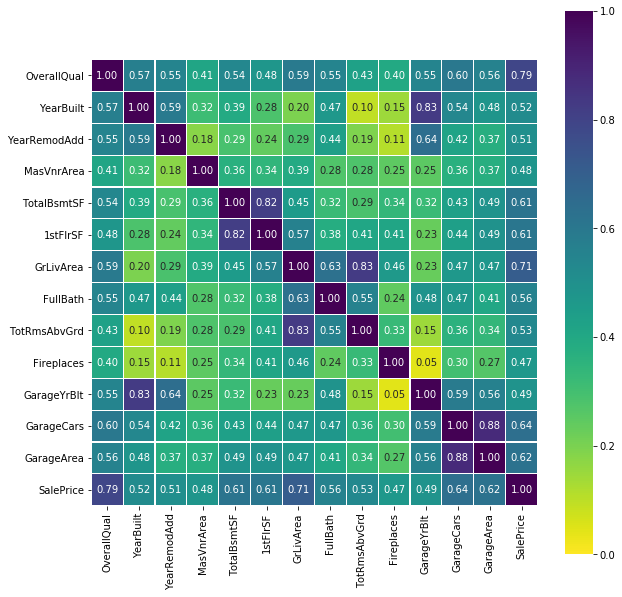

In [12]:
corr = numfeatures.corr()

#Highly Correlated Features
numfeatures_high_corr = corr[corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]].loc[
    corr.index[(corr['SalePrice']>0.40) | (corr['SalePrice']<-0.4)]]

# Heatmap 
plt.figure(figsize=(10,10))
sns.heatmap(numfeatures_high_corr,annot=True,fmt='.2f', 
            vmax=1.0, vmin=0.0,cmap='viridis_r',square=True,annot_kws={"size":10},linewidths=0.1)

highly_corr_features = numfeatures_high_corr.drop('SalePrice').index
del(numfeatures_high_corr)

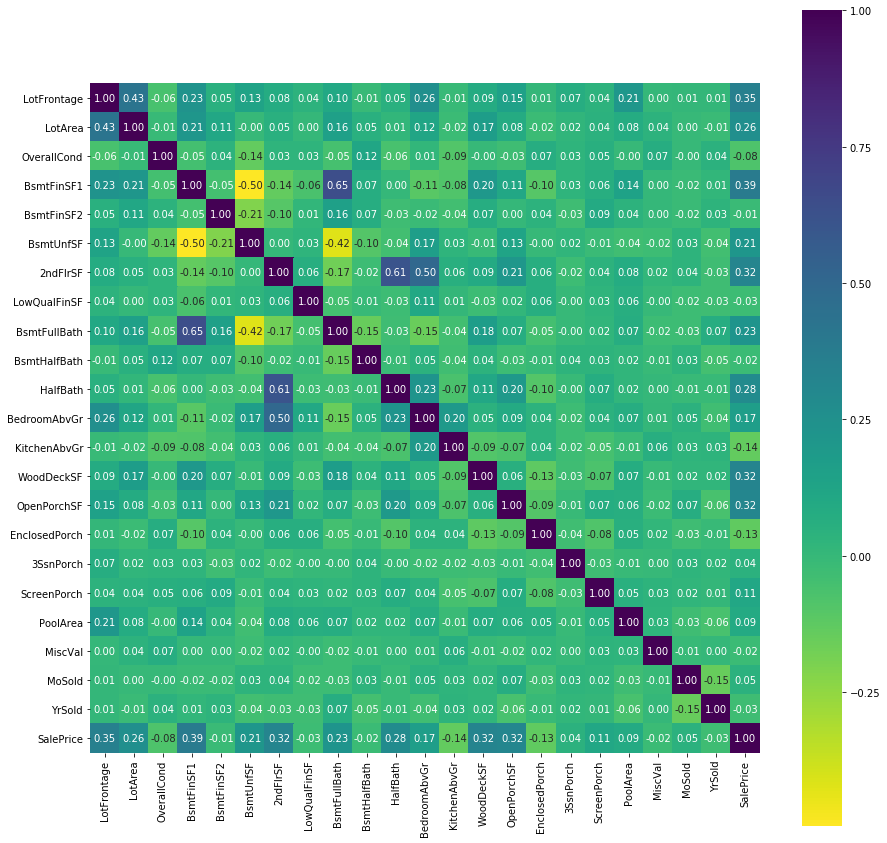

Low Corr Related Features: 
 ['LotFrontage', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [32]:
plt.figure(figsize = (15,15))
sns.heatmap(numfeatures.drop(highly_corr_features, axis=1).corr(), annot=True, fmt='.2f', square=True, cmap='viridis_r')
plt.show()
low_corr_features = numfeatures.drop(highly_corr_features, axis=1).columns
print('Low Corr Related Features: \n',low_corr_features.tolist())

Its not necessary that if the correlation of columns with target variable is low, it doesnot have any impact. Let see if we find some insight out of them.

In [45]:
def multiregression(features, target, train_test_split=True, test_size=0.33, MSE = True):
    
    if sum(features.isnull().sum())>0:
        return(ValueError('Data contains NULL values'))
        
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    regr = LinearRegression()

    
    if train_test_split==True:
        x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.33)
        
    
    else:
        x_train = features
        y_train = target
        x_test = features
        y_test = target
        
    model = regr.fit(x_train, y_train)
    predict = model.predict(x_test)
    
    if MSE==True:
        return(mean_squared_error(target, predict))
    else:
        return(predict)


In [46]:
multiregression(train[low_corr_features], train['SalePrice'])

ValueError('Data contains NULL values')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15BCC8D0>,
      dtype=object)

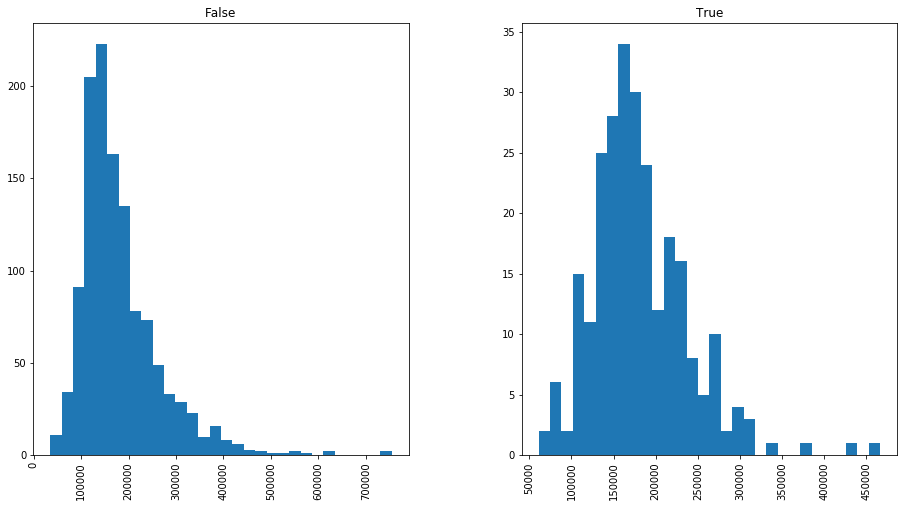

In [93]:
train[low_corr_features].isnull().sum().sort_values(ascending=False)
test_data = train.copy()
test_data['IsLotFrontage'] = test_data['LotFrontage'].isnull()
# test_data['IsLotFrontage'].replace('False', 0, inplace=True)
# test_data['IsLotFrontage'].replace('True', 1, inplace=True)
# test_data['LotFrontage'].fillna('NA')
# plt.figure(figsize=(10,10))
# sns.regplot(test_data['LotFrontage'], test_data['SalePrice'],scatter_kws={"s":100, "alpha":0.5})
test_data.hist('SalePrice',bins=30, by='IsLotFrontage', figsize=(15,8))
# test_data.IsLotFrontage.value_counts()

In [33]:
# f = pd.melt(numfeatures,
#         id_vars=['SalePrice'], 
#         value_vars=highly_corr_features)
# g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=True, size=5)
# g = g.map(sns.regplot, "value", "SalePrice", scatter_kws={"alpha":0.5,"s":50})

As we can see in the HeatMap, GarageArea and GarageCars has 0.88 correlation coefficient. Now, wea are going to dig in to do some feature engineering.

In [ ]:
train.MSSubClass.value_counts(dropna=False).sort_index().sum()
df = train.copy()
bins = [0, 1900, 1995, 2000, 2005, 2010]
df['YrBuilt_bins']=pd.cut(df['YearBuilt'], bins)

In [ ]:
sp.boxplot()

In [ ]:
pd.crosstab(index=train['Foundation'], columns=train['BsmtQual'], values=train['Id'], aggfunc='count')

# Building Model

### Spliting Data Set  

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
feats = highly_corr_features.tolist()
# feats.append('MSSubClass')
feats.remove('MasVnrArea')
feats.remove('GarageYrBlt')

In [ ]:
data = train.copy()
categorical.columns

In [ ]:
# train['enc_neighborhood']=
# pd.get_dummies(train.Neighborhood, drop_first=True)
final = pd.merge(data,pd.get_dummies(train.Neighborhood, drop_first=True), how='inner', left_index=True, right_index=True)
# train.Neighborhood.value_counts().sort_values(ascending=False)

In [ ]:
# feats = numfeatures.drop(['SalePrice','GarageYrBlt','LotFrontage','MasVnrArea'], axis=1).columns.tolist()
# feats = feats + pd.get_dummies(train.Neighborhood, drop_first=True).columns.tolist()
# feats
data[feats].isnull().sum()

In [ ]:
sum(final[feats].isnull().sum().sort_values(ascending=False))
final[feats].isnull().sum()

In [ ]:
y = np.log(data.SalePrice)
x = data[feats]
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   random_state = 42,
                                                   test_size = 0.33)

In [ ]:
regr = LinearRegression()
model = regr.fit(x_train, y_train)

In [ ]:
# feats = test[highly_corr_features].interpolate()

In [ ]:
predict = model.predict(x_test)

In [ ]:
mean_squared_error(y_test, predict)

In [ ]:
regr.coef_

### Cross Validation 

In [ ]:
from sklearn import cross_validation

In [ ]:
cv = cross_validation.KFold(len(x), n_folds=10 )

In [ ]:
result=[]
for traincv, testcv in cv:
    probs = regr.fit(x.loc[traincv], y.loc[traincv]).predict(x.loc[testcv])
    result.append(mean_squared_error(y.loc[testcv],probs))

In [ ]:
result.sort()
result

In [ ]:
test=final.copy()
test = test.interpolate()

In [ ]:
test=pd.get_dummies(test,drop_first=True)
test.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(test)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))